In [35]:
# %load_ext autoreload
# %autoreload 2
from importlib import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
from helper.helper_functions import img_one_hot
from helper.pre_process_target_input import one_hot_to_lognormed_mm
from helper.gaussian_smoothing_helper import gaussian_smoothing_target, create_gaussian_kernel_2d
import einops
import torchvision.transforms as T
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from matplotlib import animation
from scipy.stats import norm
from pysteps import verification


# mywriter =  animation.FFMpegWriter()



Pysteps configuration file found at: /home/jan/miniforge3/envs/first_CNN_on_Radolan_backup_before_wandb/lib/python3.10/site-packages/pysteps/pystepsrc


In [3]:
# Create random samples

# Parameters for the 2D Gaussian
  # Mean along each dimension
  # Standard deviation along each dimension

def create_2d_band_gaussian(mean = (0, 0), stds = (0.3, 3), size = (500, 500)):
    # Create a meshgrid for the coordinates
    x = torch.linspace(-10, 10, size[0])
    y = torch.linspace(-10, 10, size[1])
    xx, yy = torch.meshgrid(x, y, indexing="ij")
    
    # Calculate the 2D Gaussian distribution
    gaussian_2d = torch.exp(-((xx - mean[0]) ** 2 / (2 * stds[0] ** 2) + (yy - mean[1]) ** 2 / (2 * stds[1] ** 2)))
    
    gaussian_2d = gaussian_2d * 10
    
    return gaussian_2d


    
    

In [4]:
def create_2d_band_binary(offset = 0, width = 10,  size = (100, 100)):
    
    # Scale coordinate system from pixel to -10 to 10 like in gaussian function
    # scale = lambda x: x * (20/size[0]) - 10
    # scale = lambda x: x* (size[0]/20) + 10 / (20 / size[0])
    # offset = scale(offset)
    # width = scale(width)
    
    grid = torch.zeros(size)
    mean_axis_0 = size[0] / 2 + offset
    
    # Handle cases near edge
    if mean_axis_0 - width/2 < 0:
        negative_width = int(mean_axis_0)
    else:
        negative_width = int(width/2)
        
    if mean_axis_0 + width/2 > size[0]:
        positive_width = int(size[0] - mean_axis_0)
    else:
        positive_width = int(width/2)
        
    # Set band to 1
    grid[int(mean_axis_0 - negative_width) : int(mean_axis_0 + positive_width), :] = 1
    return grid

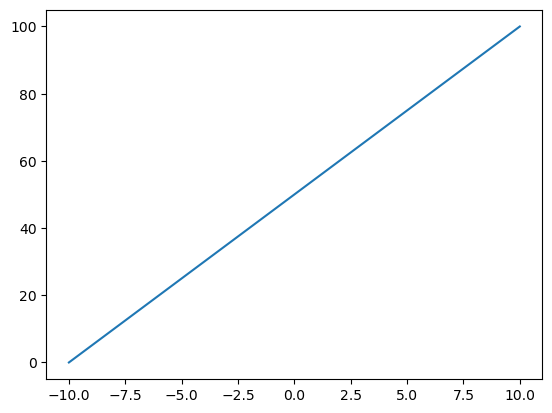

In [5]:
# transform = lambda x: x * (20/100) - 10

# transform = lambda x: x * (20/100) - 10
# y = x*w + b
# x = y/w - b/w

transform = lambda x: x/(20/100) + (10 / (20/100))

nums = np.linspace(-10, 10, 10)

plt.plot(nums, transform(nums))
plt.show()

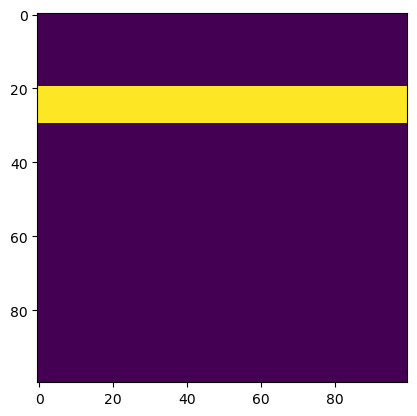

In [6]:
test = create_2d_band_binary(offset=-25, width = 10, size=(100, 100))
plt.imshow(test)
plt.show()


In [7]:
target_upper = create_2d_band_gaussian(mean = (-0, 0), stds = (0.5, 10), size = (200, 200))
pred_lower = create_2d_band_gaussian(mean = (-1, 0), stds = (0.5, 10), size = (200, 200))

target_upper = create_2d_band_binary(offset=-22, width = 10, size=(100, 100))



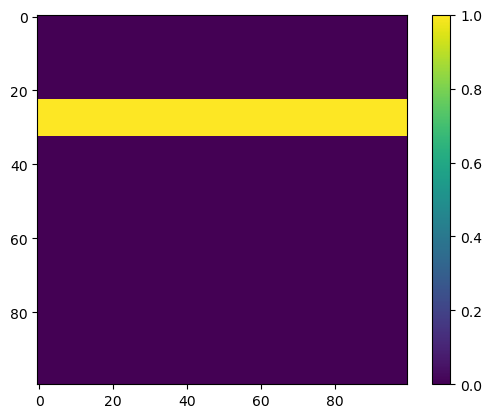

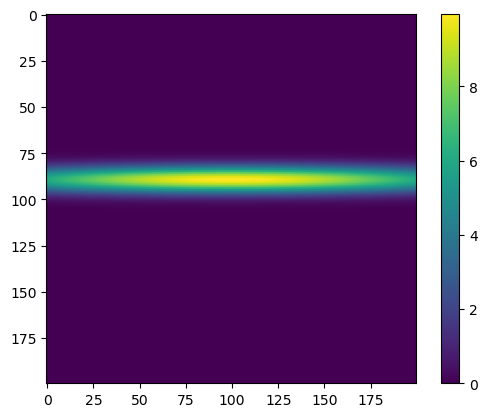

In [8]:
plt.imshow(target_upper)
plt.colorbar()
plt.show()

plt.imshow(pred_lower)
plt.colorbar()
plt.show()

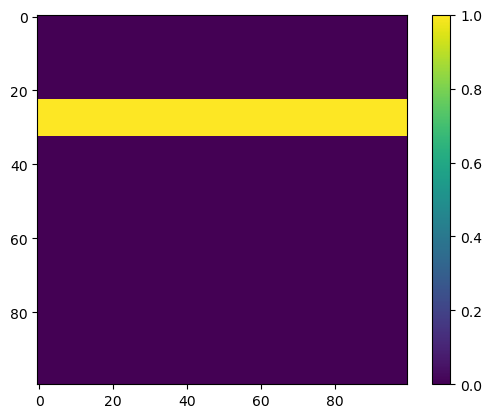

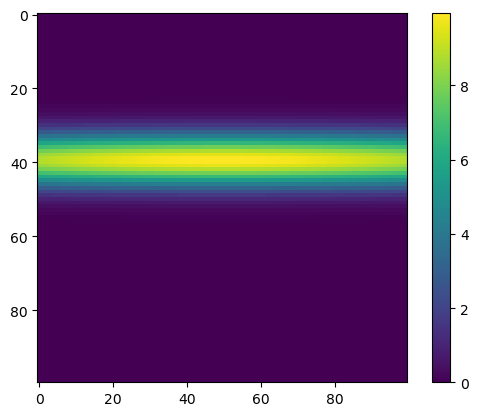

In [9]:
target_upper_pixel_wise = T.CenterCrop(size=100)(target_upper)
pred_lower_pixel_wise = T.CenterCrop(size=100)(pred_lower)

plt.imshow(target_upper_pixel_wise)
plt.colorbar()
plt.show()

plt.imshow(pred_lower_pixel_wise)
plt.colorbar()
plt.show()

In [10]:
# One Hot Encoding
linspace_binning = torch.linspace(0, 9.5, 16)
linspace_binning_max = 10

target_upper = img_one_hot(target_upper, num_c=len(linspace_binning), linspace_binning=linspace_binning)
pred_lower = img_one_hot(pred_lower, num_c=len(linspace_binning), linspace_binning=linspace_binning)





In [11]:
target_upper = einops.rearrange(target_upper, 'h w c -> 1 c h w')
pred_lower = einops.rearrange(pred_lower, 'h w c -> 1 c h w')
target_upper.shape


torch.Size([1, 16, 100, 100])

In [12]:
kernel_size = 100
sigma = 6 #8

target_upper = gaussian_smoothing_target(target_upper, sigma=sigma, kernel_size=kernel_size, device='cpu', target_size=100)
pred_lower = T.CenterCrop(size=100)(pred_lower)

RuntimeError: The size of tensor a (0) must match the size of tensor b (100) at non-singleton dimension 3

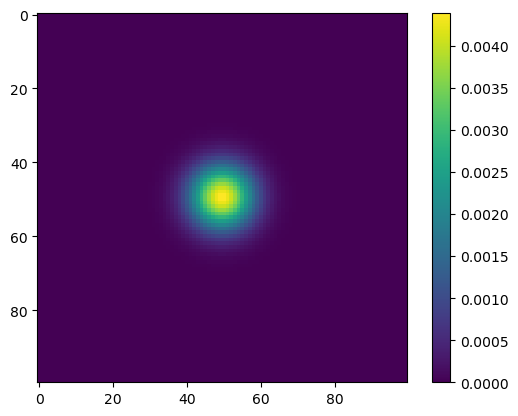

In [13]:
smoothing_kernel_replica = create_gaussian_kernel_2d(size=kernel_size, sigma=sigma)
plt.imshow(smoothing_kernel_replica)
plt.colorbar()

In [14]:
target_upper_binned = target_upper
pred_lower_binned = pred_lower

In [15]:
target_upper.shape


torch.Size([1, 16, 100, 100])

In [17]:
target_upper = one_hot_to_lognormed_mm(target_upper, linspace_binning, channel_dim=1)
pred_lower = one_hot_to_lognormed_mm(pred_lower, linspace_binning, channel_dim=1)

target_upper = target_upper[0]
pred_lower = pred_lower[0]


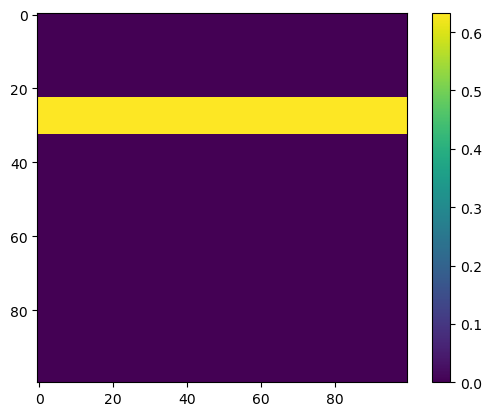

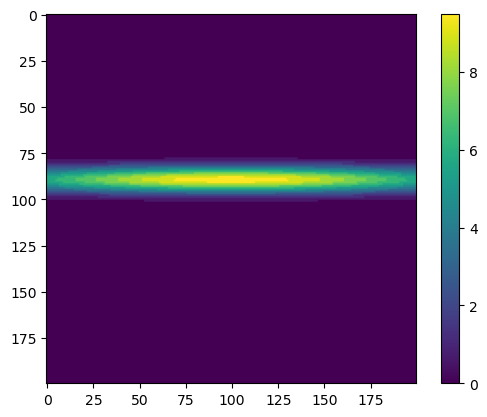

In [18]:
plt.imshow(target_upper)
plt.colorbar()
plt.show()

plt.imshow(pred_lower)
plt.colorbar()
plt.show()

In [19]:
target_upper.shape


torch.Size([100, 100])

In [20]:
pred_lower.shape

torch.Size([200, 200])

In [22]:
rmse = torch.sqrt(torch.nn.MSELoss()(pred_lower_pixel_wise, target_upper_pixel_wise))
print(rmse)

tensor(2.8360)


In [27]:
pred_lower_binned.shape

torch.Size([1, 16, 200, 200])

In [28]:
target_upper_binned.shape

torch.Size([1, 16, 100, 100])

In [26]:
dlbd = torch.nn.CrossEntropyLoss()(
    pred_lower_binned[0,...].float(),
    target_upper_binned[0,...].float())

RuntimeError: Expected target size [16, 200], got [16, 100, 100]

In [24]:
print(dlbd)

NameError: name 'dlbd' is not defined

In [29]:
def get_scaling_function(a, b, c, d):
    """
    Creates a scaling function to map a range [a, b] to [c, d].

    Returns function
    """
    scale = (d - c) / (b - a)
    return lambda x: (x - a) * scale + c


# def get_scaling_function(a, b, c, d):
#     """
#     Creates a scaling function to map a range [a, b] to [c, d].
# 
#     Returns function
#     """
#     scale = (d - c) / (b - a)
#     return lambda x: x


MovieWriter ffmpeg unavailable; using Pillow instead.


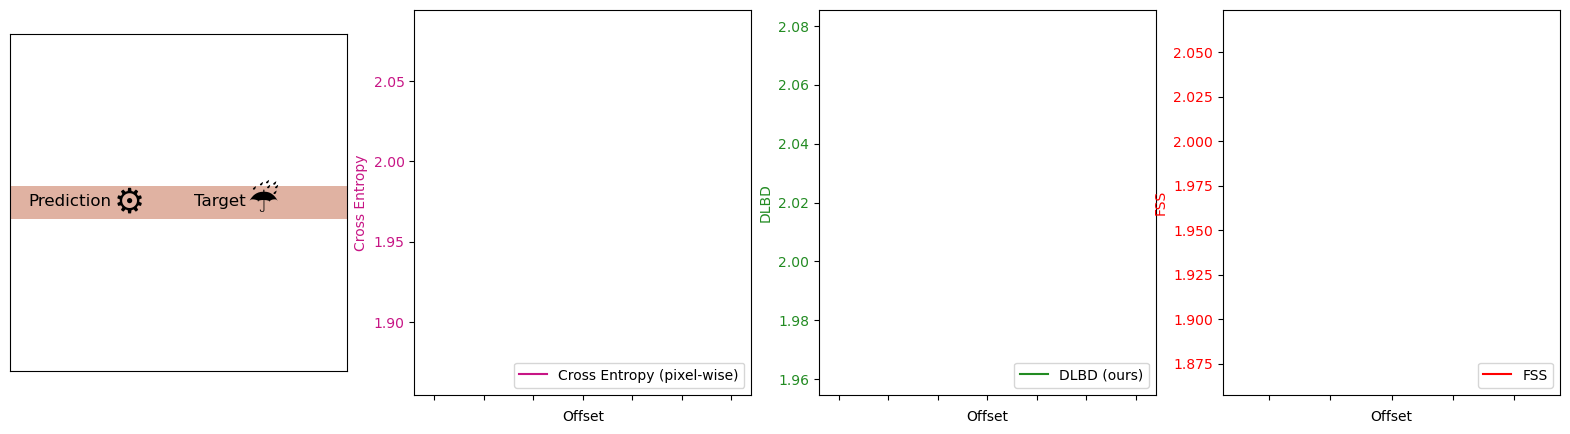

In [39]:
### CREATE ANIMATION COMPARING XENTROPY AND DLBD ###

# # Create binning
# linspace_binning = torch.linspace(0, 9.5, 16)
# linspace_binning_max = 10
# 
# # smoothing parameters
# kernel_size = 100
# sigma = 6
# 
# # Create offsets
# # offsets = np.linspace(0, 5.5, 30) # Corrected offsets creation
# offsets = np.arange(0, 30, 1) # Corrected offsets creation

fss_calc_steps = verification.get_method("FSS")


offsets=np.arange(0, 30, 1)




def create_frames(num_frames, sigma=6, kernel_size=100, offsets=np.arange(0, 30, 1), linspace_binning=torch.linspace(0, 9.5, 16), linspace_binning_max=10):
    target_pixel_frames = []
    pred_pixel_frames = []

    
    rmses = []
    dlbds = []
    fss_list = []
    
    for frame in range(num_frames):

        
        offset = offsets[frame]
        
        # target_upper = create_2d_grid(mean=(-0, 0), stds=(0.5, 10), size=(200, 200))
        # pred_lower = create_2d_grid(mean=(-offset, 0), stds=(0.5, 10), size=(200, 200))
        target_upper = create_2d_band_binary(0, width=10, size=(200,200))
        pred_lower = create_2d_band_binary(offset, width=10, size=(200,200))
        
        
        # CenterCrop for actual representation
        target_upper_pixel_wise = T.CenterCrop(size=100)(target_upper.unsqueeze(0))
        pred_lower_pixel_wise = T.CenterCrop(size=100)(pred_lower.unsqueeze(0))
        
        target_pixel_frames.append(target_upper_pixel_wise)
        pred_pixel_frames.append(pred_lower_pixel_wise)
        
        # One Hot Encoding
        target_upper_mm = target_upper
        pred_lower_mm = pred_lower
        
        target_upper = img_one_hot(target_upper, num_c=len(linspace_binning), linspace_binning=linspace_binning)
        
        pred_lower = img_one_hot(pred_lower, num_c=len(linspace_binning), linspace_binning=linspace_binning)
        
        target_upper = einops.rearrange(target_upper, 'h w c -> 1 c h w')
        pred_lower = einops.rearrange(pred_lower, 'h w c -> 1 c h w')
        
        target_upper_one_hot = target_upper
        pred_lower = T.CenterCrop(size=100)(pred_lower)
        target_upper_one_hot = T.CenterCrop(size=100)(target_upper_one_hot)
        
        target_upper_dlbd = gaussian_smoothing_target(target_upper, sigma=sigma, kernel_size=kernel_size, device='cpu', target_size=100)
        
        # Scale Xentropy meaningfully

        scale_rmse = get_scaling_function(1.85, 2.1, 0, 1)
        scale_dlbd = get_scaling_function(1.95, 2.09, 0, 1)
        
        # rmse = torch.sqrt(torch.nn.MSELoss()(pred_lower_pixel_wise, target_upper_pixel_wise))
        rmse = torch.nn.CrossEntropyLoss()(pred_lower.float(), target_upper_one_hot.float())
        dlbd = torch.nn.CrossEntropyLoss()(pred_lower.float(), target_upper_dlbd.float())
        fss = fss_calc_steps(pred_lower_mm.detach().cpu().numpy(),
                             target_upper_mm.detach().cpu().numpy(),
                             thr=10, scale=10)
        
        
        # rmse = scale_rmse(rmse)
        # dlbd = scale_dlbd(dlbd)
        
        rmses.append(rmse)
        dlbds.append(dlbd)
        fss_list.append(fss)
        
    return target_pixel_frames, pred_pixel_frames, rmses, dlbds

    
def update(frame_idx, target_pixel_frames, pred_pixel_frames, rmses, dlbds, offsets):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()  # Clear the DLBD plot
    ax[3].clear()
    
    # Create a custom colormap
    # 'black' with alpha 0 for transparent, and 'coral' with alpha 1 for opaque
    colors_target = [(1, 1, 1, 0), 'coral']  # RGBA values
    cmap_target = ListedColormap(colors_target)
    
    colors_pred = [(1, 1, 1, 0), 'skyblue']  # RGBA values
    cmap_pred = ListedColormap(colors_pred)
    
    # Plot the target and prediction
    ax[0].imshow(target_pixel_frames[frame_idx].squeeze(), extent=[0, 100, 0, 100], origin='lower', alpha=0.5, cmap=cmap_pred)
    ax[0].imshow(pred_pixel_frames[frame_idx].squeeze(), extent=[0, 100, 0, 100], origin='lower', alpha=0.5, cmap=cmap_target)
    
    
    # Adding labels with some distance to avoid overlap
    # Note: Adjust `5` and `10` to change the label positions if necessary
    # Load Apple Color Emoji font 
    
    curr_offset = offsets[frame_idx]
    ax[0].text(30, 48, 'Prediction', ha='right', va='bottom', fontsize=12, )
    ax[0].text(40, 45, '⚙️', ha='right', va='bottom', fontsize=25, )
    
    
    ax[0].text(70, 48 + curr_offset, 'Target', ha='right', va='bottom', fontsize=12)
    ax[0].text(80, 45 + curr_offset, '☔️', ha='right', va='bottom', fontsize=25)

    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Plot the RMSE and DLBD
    
   # Plot Cross Entropy
    rmse_color = 'mediumvioletred'
    ax[1].plot(rmses[:frame_idx + 1], label='Cross Entropy (pixel-wise)', color=rmse_color)
    ax[1].set_ylabel('Cross Entropy', color=rmse_color)
    ax[1].tick_params(axis='y', labelcolor=rmse_color)
    
    # Plot DLBD on a separate subplot
    dlbd_color = 'forestgreen'
    ax[2].plot(dlbds[:frame_idx + 1], label='DLBD (ours)', color=dlbd_color)
    ax[2].set_ylabel('DLBD', color=dlbd_color)
    ax[2].tick_params(axis='y', labelcolor=dlbd_color)
    
    # Plot FSS on seperate subplt
    fss_color = 'red'
    ax[3].plot(dlbds[:frame_idx + 1], label='FSS', color=fss_color)
    ax[3].set_ylabel('FSS', color=fss_color)
    ax[3].tick_params(axis='y', labelcolor=fss_color)
    
    # Set y-axis limits
    rmse_val_range = max(rmses) - min(rmses)
    dlbds_val_range = max(dlbds) - min(dlbds)
    ax[1].set_ylim([min(rmses) - rmse_val_range * 0.1, max(rmses) + rmse_val_range * 0.1])
    ax[2].set_ylim([min(dlbds) - dlbds_val_range * 0.1, max(dlbds) + dlbds_val_range * 0.1])
    
    ax[1].set_xlim([-2, len(target_pixel_frames) + 2])
    ax[2].set_xlim([-2, len(target_pixel_frames) + 2])
    
    # Legends
    ax[1].legend(loc='lower right')
    ax[2].legend(loc='lower right')
    ax[3].legend(loc='lower right')
    
    
    ax[1].set_xticklabels([])
    ax[2].set_xticklabels([])
    ax[3].set_xticklabels([])

    # Only set xlabel for the bottom-most plots (or the last in your layout)
    ax[1].set_xlabel('Offset')
    ax[2].set_xlabel('Offset')
    ax[3].set_xlabel('Offset')
    


# Set up figure and subplots
fig, ax = plt.subplots(1, 4, figsize=(20, 5))     
    
target_pixel_frames, pred_pixel_frames, rmses, dlbds = create_frames(len(offsets))

ani = FuncAnimation(fig, lambda frame_idx: update(frame_idx, target_pixel_frames, pred_pixel_frames, rmses, dlbds, offsets), frames=len(offsets), repeat=False)
# ani.save('/Users/jan/Downloads/animation51.mp4', writer='ffmpeg', fps=5)
# ani.save('/Users/jan/Downloads/animation54_no_scaling.gif', writer='ffmpeg', fps=5, dpi=150)
ani.save('/home/jan/Downloads/animation_test2.gif', writer='ffmpeg', fps=5, dpi=150)


MovieWriter ffmpeg unavailable; using Pillow instead.


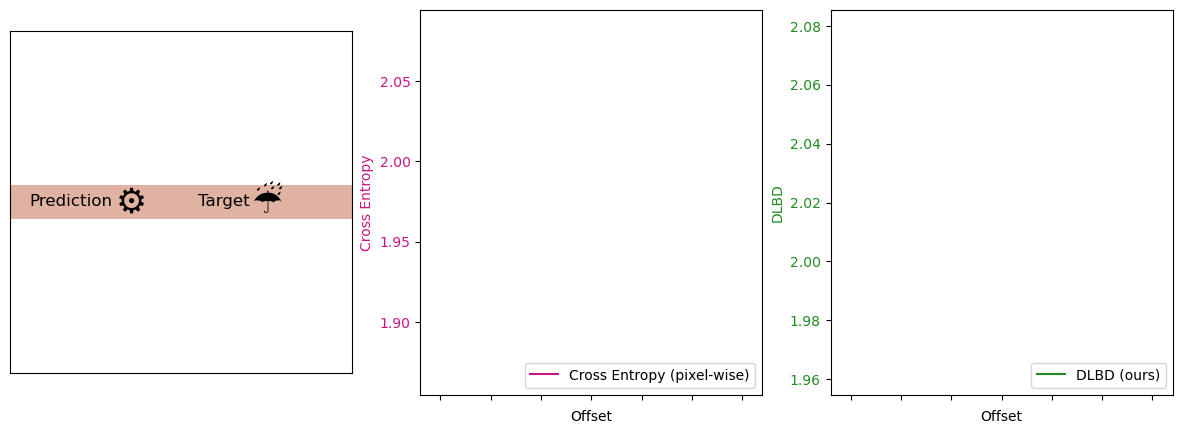

In [32]:
### CREATE ANIMATION COMPARING XENTROPY AND DLBD ###

# # Create binning
# linspace_binning = torch.linspace(0, 9.5, 16)
# linspace_binning_max = 10
# 
# # smoothing parameters
# kernel_size = 100
# sigma = 6
# 
# # Create offsets
# # offsets = np.linspace(0, 5.5, 30) # Corrected offsets creation
# offsets = np.arange(0, 30, 1) # Corrected offsets creation

offsets=np.arange(0, 30, 1)




def create_frames(num_frames, sigma=6, kernel_size=100, offsets=np.arange(0, 30, 1), linspace_binning=torch.linspace(0, 9.5, 16), linspace_binning_max=10):
    target_pixel_frames = []
    pred_pixel_frames = []

    
    rmses = []
    dlbds = []
    
    for frame in range(num_frames):

        
        offset = offsets[frame]
        
        # target_upper = create_2d_grid(mean=(-0, 0), stds=(0.5, 10), size=(200, 200))
        # pred_lower = create_2d_grid(mean=(-offset, 0), stds=(0.5, 10), size=(200, 200))
        target_upper = create_2d_band_binary(0, width=10, size=(200,200))
        pred_lower = create_2d_band_binary(offset, width=10, size=(200,200))
        
        
        # CenterCrop for actual representation
        target_upper_pixel_wise = T.CenterCrop(size=100)(target_upper.unsqueeze(0))
        pred_lower_pixel_wise = T.CenterCrop(size=100)(pred_lower.unsqueeze(0))
        
        target_pixel_frames.append(target_upper_pixel_wise)
        pred_pixel_frames.append(pred_lower_pixel_wise)
        
        # One Hot Encoding
        target_upper = img_one_hot(target_upper, num_c=len(linspace_binning), linspace_binning=linspace_binning)
        
        pred_lower = img_one_hot(pred_lower, num_c=len(linspace_binning), linspace_binning=linspace_binning)
        
        target_upper = einops.rearrange(target_upper, 'h w c -> 1 c h w')
        pred_lower = einops.rearrange(pred_lower, 'h w c -> 1 c h w')
        
        target_upper_one_hot = target_upper
        pred_lower = T.CenterCrop(size=100)(pred_lower)
        target_upper_one_hot = T.CenterCrop(size=100)(target_upper_one_hot)
        
        target_upper_dlbd = gaussian_smoothing_target(target_upper, sigma=sigma, kernel_size=kernel_size, device='cpu', target_size=100)
        
        # Scale Xentropy meaningfully

        scale_rmse = get_scaling_function(1.85, 2.1, 0, 1)
        scale_dlbd = get_scaling_function(1.95, 2.09, 0, 1)
        
        # rmse = torch.sqrt(torch.nn.MSELoss()(pred_lower_pixel_wise, target_upper_pixel_wise))
        rmse = torch.nn.CrossEntropyLoss()(pred_lower.float(), target_upper_one_hot.float())
        dlbd = torch.nn.CrossEntropyLoss()(pred_lower.float(), target_upper_dlbd.float())
        
        
        # rmse = scale_rmse(rmse)
        # dlbd = scale_dlbd(dlbd)
        
        rmses.append(rmse)
        dlbds.append(dlbd)
        
    return target_pixel_frames, pred_pixel_frames, rmses, dlbds

    
def update(frame_idx, target_pixel_frames, pred_pixel_frames, rmses, dlbds, offsets):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()  # Clear the DLBD plot
    
    # Create a custom colormap
    # 'black' with alpha 0 for transparent, and 'coral' with alpha 1 for opaque
    colors_target = [(1, 1, 1, 0), 'coral']  # RGBA values
    cmap_target = ListedColormap(colors_target)
    
    colors_pred = [(1, 1, 1, 0), 'skyblue']  # RGBA values
    cmap_pred = ListedColormap(colors_pred)
    
    # Plot the target and prediction
    ax[0].imshow(target_pixel_frames[frame_idx].squeeze(), extent=[0, 100, 0, 100], origin='lower', alpha=0.5, cmap=cmap_pred)
    ax[0].imshow(pred_pixel_frames[frame_idx].squeeze(), extent=[0, 100, 0, 100], origin='lower', alpha=0.5, cmap=cmap_target)
    
    
    # Adding labels with some distance to avoid overlap
    # Note: Adjust `5` and `10` to change the label positions if necessary
    # Load Apple Color Emoji font 
    
    curr_offset = offsets[frame_idx]
    ax[0].text(30, 48, 'Prediction', ha='right', va='bottom', fontsize=12, )
    ax[0].text(40, 45, '⚙️', ha='right', va='bottom', fontsize=25, )
    
    
    ax[0].text(70, 48 + curr_offset, 'Target', ha='right', va='bottom', fontsize=12)
    ax[0].text(80, 45 + curr_offset, '☔️', ha='right', va='bottom', fontsize=25)

    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Plot the RMSE and DLBD
    
   # Plot Cross Entropy
    rmse_color = 'mediumvioletred'
    ax[1].plot(rmses[:frame_idx + 1], label='Cross Entropy (pixel-wise)', color=rmse_color)
    ax[1].set_ylabel('Cross Entropy', color=rmse_color)
    ax[1].tick_params(axis='y', labelcolor=rmse_color)
    
    # Plot DLBD on a separate subplot
    dlbd_color = 'forestgreen'
    ax[2].plot(dlbds[:frame_idx + 1], label='DLBD (ours)', color=dlbd_color)
    ax[2].set_ylabel('DLBD', color=dlbd_color)
    ax[2].tick_params(axis='y', labelcolor=dlbd_color)
    
    # Set y-axis limits
    rmse_val_range = max(rmses) - min(rmses)
    dlbds_val_range = max(dlbds) - min(dlbds)
    ax[1].set_ylim([min(rmses) - rmse_val_range * 0.1, max(rmses) + rmse_val_range * 0.1])
    ax[2].set_ylim([min(dlbds) - dlbds_val_range * 0.1, max(dlbds) + dlbds_val_range * 0.1])
    
    ax[1].set_xlim([-2, len(target_pixel_frames) + 2])
    ax[2].set_xlim([-2, len(target_pixel_frames) + 2])
    
    # Legends
    ax[1].legend(loc='lower right')
    ax[2].legend(loc='lower right')
    
    ax[1].set_xticklabels([])
    ax[2].set_xticklabels([])

    # Only set xlabel for the bottom-most plots (or the last in your layout)
    ax[1].set_xlabel('Offset')
    ax[2].set_xlabel('Offset')


# Set up figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))     
    
target_pixel_frames, pred_pixel_frames, rmses, dlbds = create_frames(len(offsets))

ani = FuncAnimation(fig, lambda frame_idx: update(frame_idx, target_pixel_frames, pred_pixel_frames, rmses, dlbds, offsets), frames=len(offsets), repeat=False)
# ani.save('/Users/jan/Downloads/animation51.mp4', writer='ffmpeg', fps=5)
# ani.save('/Users/jan/Downloads/animation54_no_scaling.gif', writer='ffmpeg', fps=5, dpi=150)
ani.save('/home/jan/Downloads/animation54_no_scaling.gif', writer='ffmpeg', fps=5, dpi=150)


In [ ]:

# sigmas = np.logspace(-1, np.log10(20), 10)
sigmas = np.linspace(0.1, 20, 150)

sigmas = sigmas[::-1]

dlbds_list = []

for sigma in sigmas:
    target_pixel_frames, pred_pixel_frames, rmses, dlbds = create_frames(num_frames=30, sigma=sigma)
    dlbds_list.append(dlbds)


def gaussian(sigma, max_sigma):
    x = np.linspace(-3*max_sigma, 3*max_sigma, 1000)
    y = norm.pdf(x, 0, sigma)
    return x, y
    

def update(frame_idx, dlbds_list, sigmas):
    ax[0].clear()
    ax[1].clear()
    
    # Update data for the current frame
    dlbds = dlbds_list[frame_idx]
    sigma = sigmas[frame_idx]

    x, y = gaussian(sigma, max(sigmas))
    # Estimate y_max from highest gaussian (lowest sigma)
    _, y_max_dist = gaussian(min(sigmas), max(sigmas))
    y_max = max(y_max_dist)


    # Plot Gaussian distribution
    ax[0].plot(x, y)
    ax[0].set_xlim(-3*max(sigmas), 3*max(sigmas))
    # ax[0].set_ylim(-0.01 * y_max, 1.01 * y_max)
    
    ax[0].set_title(f'Gaussian Kernel σ={sigma:.2f}')
    
    # Remove x-axis labels and ticks from the first subplot
    ax[0].xaxis.set_ticks([])
    ax[0].xaxis.set_ticklabels([])
    
    # Remove y-axis labels and ticks from the first subplot
    ax[0].yaxis.set_ticks([])
    ax[0].yaxis.set_ticklabels([])
    
    # Plot DLBD on a separate subplot
    dlbd_color = 'forestgreen'
    ax[1].plot(dlbds, label='DLBD (ours)', color=dlbd_color)
    # ax[1].set_ylim(-0.1, 1.1)
    
    ax[1].set_ylabel('DLBD', color=dlbd_color)
    ax[1].tick_params(axis='y', labelcolor=dlbd_color)
    
    ax[1].set_xticklabels([])
    ax[1].set_xlabel('Offset')
    ax[1].legend(loc='lower right')
    
    # Remove y-axis labels and ticks from the second subplot
    ax[1].yaxis.set_ticks([])
    ax[1].yaxis.set_ticklabels([])

    fig.tight_layout()
    
    
# Set up the plotting framework
fig, ax = plt.subplots(1, 2, figsize=(12, 6))    
    
ani = FuncAnimation(fig, lambda frame_idx: update(frame_idx, dlbds_list, sigmas), frames=len(sigmas), repeat=False)
ani.save('/Users/jan/Downloads/animation_sigma_21_lin_final.mp4', writer='ffmpeg', fps=30)



    

In [12]:
sigmas = np.logspace(-1, 1, 3)
print(sigmas)

[ 0.1  1.  10. ]


In [13]:
_, y_max = gaussian(min(sigmas), max(sigmas))
y_max_y = max(y_max)
print(y_max_y)

NameError: name 'gaussian' is not defined

In [650]:
x, y = gaussian(min(sigmas), max(sigmas))
y

array([0.00073864, 0.0008843 , 0.0010548 , 0.00125355, 0.0014843 ,
       0.00175108, 0.00205824, 0.0024104 , 0.00281247, 0.00326958,
       0.00378704, 0.00437031, 0.00502494, 0.00575643, 0.00657023,
       0.00747158, 0.00846544, 0.00955633, 0.01074825, 0.01204451,
       0.01344762, 0.01495913, 0.01657952, 0.01830807, 0.02014271,
       0.02207995, 0.02411476, 0.02624053, 0.02844901, 0.03073027,
       0.03307277, 0.03546332, 0.03788725, 0.04032845, 0.04276957,
       0.04519214, 0.04757686, 0.04990378, 0.05215259, 0.05430292,
       0.0563346 , 0.05822802, 0.05996443, 0.0615262 , 0.0628972 ,
       0.06406301, 0.0650112 , 0.06573154, 0.06621619, 0.06645986,
       0.06645986, 0.06621619, 0.06573154, 0.0650112 , 0.06406301,
       0.0628972 , 0.0615262 , 0.05996443, 0.05822802, 0.0563346 ,
       0.05430292, 0.05215259, 0.04990378, 0.04757686, 0.04519214,
       0.04276957, 0.04032845, 0.03788725, 0.03546332, 0.03307277,
       0.03073027, 0.02844901, 0.02624053, 0.02411476, 0.02207

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Since the direct loading of TTC files might be problematic, we switch strategies:
# Explicitly use a specific font without using FontProperties if problems persist

# Set up plot
freqs = [301, 96, 53, 81, 42]
labels = ['☔️', '☔︎', '🛰️', '🔮', '⚙️']
plt.figure(figsize=(12,8))
p1 = plt.bar(np.arange(len(labels)), freqs, 0.8, color="lightblue")
plt.ylim(0, plt.ylim()[1]+30)

# Make labels, possibly without FontProperties if it still fails
for rect1, label in zip(p1, labels):
    height = rect1.get_height()
    plt.annotate(
        label,
        (rect1.get_x() + rect1.get_width()/2, height+5),
        ha="center",
        va="bottom",
        fontsize=12  # Specify fontsize directly, no FontProperties
    )

plt.show()


In [ ]:
🕹️